In [1]:
from tensorflow.keras import layers, optimizers, Model, callbacks, initializers, utils
from tensorflow.keras.constraints import max_norm
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
import threading
import soundfile as sf
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy import signal
import subprocess
import shutil
import time
import gc
import random
import os

DATA_PATH = r"..\\data"
TRAIN_DATASET_PATH = r"..\\train_dataset"
TEST_DATASET_PATH = r"..\\test_dataset"
VAL_SPLIT = 0.2

MAX_SAMPLE_FREQUENCY = 256_000

FRAME_SIZE = 4096
FRAME_OVERLAP = 2048

MAXIMUM_NUMBER_OF_NOISE_CHANNELS = 8
NOISE_APLITUDE_MAX = 4
NOISE_FREQ_MAX = 48_000

PRETRAIN_EPOCHS = 2
EPOCHS = 40
STEPES_PER_EPOCH = 5_000
BATCH_SIZE = 32

frame_shift = FRAME_SIZE - FRAME_OVERLAP

Loading data

In [2]:
def find_files(files, dirs=[], extensions=[]):
    new_dirs = []
    for d in dirs:
        if not os.path.exists(d): continue
        
        try:
            new_dirs += [ os.path.join(d, f) for f in os.listdir(d) ]
        except OSError:
            if os.path.splitext(d)[1] in extensions:
                files.append(d)

    if new_dirs:
        find_files(files, new_dirs, extensions)
    else:
        return

In [3]:
# Convert all mp3 files to wav
def convert_all_files():
    for file_path in file_paths:
        cleaned_name = file_path[:-4]

        if file_path[-4:] == ".mp3":
            new_name = cleaned_name + ".wav"

            sound = AudioSegment.from_file(file_path, format="mp3")
            sound.export(new_name, "wav")

            os.remove(file_path)
        elif file_path[-4:] == ".mp4":
            subprocess.Popen(f"ffmpeg -i {file_path} -vn -acodec pcm_s16le -ar 44100 -ac 2 {cleaned_name}.wav").wait()
            os.remove(file_path)

Process data

In [4]:
def normalization(samples:np.ndarray):
    smpl = samples.copy()
    max_abs_val = max(abs(smpl))

    # Normalization
    smpl /= max_abs_val
    return smpl

In [5]:
def noise_data(data, fs):
  sdata = data.copy()

  length_in_secs = sdata.size / fs
  time = np.linspace(0, length_in_secs, sdata.size, endpoint=False)

  for _ in range(random.randint(1, MAXIMUM_NUMBER_OF_NOISE_CHANNELS)):
    sdata += (random.random() * NOISE_APLITUDE_MAX) * np.cos(2 * np.pi * (random.random() * NOISE_FREQ_MAX) * time + (random.random() * 2 * np.pi))
  
  return sdata

In [6]:
def create_frames(data:np.ndarray):
  number_of_frames = data.size // frame_shift
  frames = [data[idx * frame_shift : FRAME_SIZE + idx * frame_shift] for idx in range(number_of_frames)]
  frames[len(frames) - 1] = np.pad(frames[len(frames) - 1], (0, FRAME_SIZE - frames[len(frames) - 1].shape[0]), "constant")
  return frames

In [7]:
def drawFFT(signal, frequency, idx=None):
  fft = np.fft.fft(signal)

  data_length = len(signal)
  freq = np.arange(data_length)/(data_length/frequency)

  half_length = data_length//2

  freq_one_side = freq[:half_length]
  fft = fft[:half_length]/half_length

  plt.figure(figsize=(18,8))
  plt.title(f"FFT {idx}" if idx is not None else "Generic FFT")
  plt.plot(freq_one_side, abs(fft))
  plt.xlabel('f[Hz]')
  plt.ylabel('Amplituda[-]')
  plt.tight_layout()
  plt.show()

In [8]:
def process_one_file(smpls, fs):
  # Split and normalize
  try:
    if smpls.shape[1] > 0:
      normalized_samples = []

      for i in range(smpls.shape[1]):
        normalized_samples.extend(normalization(smpls[:, i]))

      normalized_samples = np.array(normalized_samples)
    else:
      normalized_samples = normalization(smpls)
  except Exception as e:
    print(f"Exception on spliting data\n{e}")
    normalized_samples = normalization(smpls)

  # Create noised data and normalize them
  noised_samples = noise_data(normalized_samples, fs)
  noised_samples = normalization(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples.size) / fs, normalized_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples.size) / fs, noised_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # Power density
  # f1, Pxx1 = signal.periodogram(normalized_samples, fs, scaling="density")
  # print(f1.shape)
  # print(Pxx1.shape)

  # plt.semilogy(f1, Pxx1)
  # plt.title("original")
  # plt.xlabel('f[Hz]')
  # plt.ylabel('PSD [V**2/Hz]')
  # plt.show()

  # f2, Pxx2 = signal.periodogram(noised_samples, fs, scaling="density")
  # print(f2.shape)
  # print(Pxx2.shape)

  # plt.semilogy(f2, Pxx2)
  # plt.title("noised")
  # plt.xlabel('f[Hz]')
  # plt.ylabel('PSD [V**2/Hz]')
  # plt.show()

  # FFT
  # normal_fft = np.fft.fft(normalized_samples)
  # noise_fft = np.fft.fft(noised_samples)

  # print(normal_fft.shape)
  # print(noise_fft.shape)

  # data_length = len(normal_fft)
  # freq = np.arange(data_length)/(data_length/fs)

  # half_length = data_length//2

  # freq_one_side = freq[:half_length]
  # normal_fft = normal_fft[:half_length]/half_length
  # noise_fft = noise_fft[:half_length]/half_length

  # plt.figure(figsize=(18,8))
  # plt.title(f"Normal")
  # plt.plot(freq_one_side, abs(normal_fft))
  # plt.xlabel('f[Hz]')
  # plt.ylabel('Amplituda[-]')
  # plt.tight_layout()
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.title(f"Noise")
  # plt.plot(freq_one_side, abs(noise_fft))
  # plt.xlabel('f[Hz]')
  # plt.ylabel('Amplituda[-]')
  # plt.tight_layout()
  # plt.show()

  # Set signals to be between 0 and 1
  normalized_samples += 1
  noised_samples += 1
  normalized_samples = normalization(normalized_samples)
  noised_samples = normalization(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples.size) / fs, normalized_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples.size) / fs, noised_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # Create frames
  normalized_samples = create_frames(normalized_samples)
  noised_samples = create_frames(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples[50].size) / fs, normalized_samples[50])
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples[50].size) / fs, noised_samples[50])
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  return normalized_samples, noised_samples

Process data

In [9]:
def move_file(src, dest):
  name = Path(src).name
  shutil.move(src, os.path.join(dest, name))

def move_files(file_paths, target_path):
  for file_path in file_paths:
    move_file(file_path, target_path)

file_paths = []
find_files(file_paths, dirs=[DATA_PATH], extensions=[".mp3", ".mp4"])
print("Files to convert")
print(len(file_paths))

convert_all_files()
    
already_used_filenames = []
find_files(already_used_filenames, dirs=[TEST_DATASET_PATH, TRAIN_DATASET_PATH], extensions=[".npy"])

if not os.path.exists("tmp_dataset"):
  os.mkdir("tmp_dataset")

  file_paths = []
  find_files(file_paths, dirs=[DATA_PATH], extensions=[".wav"])

  print("Numbe of source files")
  print(len(file_paths))

  for file_path in tqdm(file_paths):
    cleaned_name = Path(file_path).name[:-4]

    if (any([cleaned_name in file_name for file_name in already_used_filenames]) or
        any([cleaned_name in file_name for file_name in os.listdir("tmp_dataset")])):
      print(f"Skipping {cleaned_name}")
      continue

    smpls, f = sf.read(file_path)
    gc.collect()

    print(f"Processing {cleaned_name}")
        
    random.seed()
    norm_s, nois_s = process_one_file(smpls, f)

    for idx, (a, b) in enumerate(zip(norm_s, nois_s)):
      if not os.path.exists(f"tmp_dataset/{idx}_{cleaned_name}_{f}"):
        np.save(f"tmp_dataset/{idx}_{cleaned_name}_{f}", np.array([a, b, np.fft.fft(b)]))
    gc.collect()

file_paths = []
find_files(file_paths, dirs=["tmp_dataset"], extensions=[".npy"])
number_of_files = len(file_paths)

print("Files to sort")
print(number_of_files)

if number_of_files > 0:
  random.shuffle(file_paths)

  if not os.path.exists(TEST_DATASET_PATH):
    os.mkdir(TEST_DATASET_PATH)

  if not os.path.exists(TRAIN_DATASET_PATH):
    os.mkdir(TRAIN_DATASET_PATH)

  print("Moving files")
  valid_file_count = int(number_of_files * VAL_SPLIT)
  move_files(file_paths[:valid_file_count], TEST_DATASET_PATH)
  move_files(file_paths[valid_file_count:], TRAIN_DATASET_PATH)

shutil.rmtree("tmp_dataset")

Files to convert
0
Numbe of source files
41


  2%|▏         | 1/41 [00:00<00:09,  4.37it/s]

Skipping Y2Mate.is - 15 Biggest And Most Expensive Mining FINDS-GAwIKLthp-U-48k-1639522068716


  5%|▍         | 2/41 [00:00<00:09,  4.16it/s]

Skipping Y2Mate.is - Can 3 Gamers Beat 1 Trackmania Pro Driving Backwards-DqmSovzS8HY-48k-1639525438813


  7%|▋         | 3/41 [00:00<00:09,  4.00it/s]

Skipping Y2Mate.is - Chernobyl (2019) - It's not 3 Roentgen it is 15000 scene.-yPRMx2k1NM8-128k-1639552069014


 10%|▉         | 4/41 [00:01<00:09,  3.91it/s]

Skipping Y2Mate.is - CHUNGUS 2 - A very powerful 1Hz Minecraft CPU-FDiapbD0Xfg-128k-1639551674784


 15%|█▍        | 6/41 [00:01<00:08,  4.23it/s]

Skipping Y2Mate.is - CHUNGUS 2 - A very powerful 1Hz Minecraft CPU-FDiapbD0Xfg-160k-1639551674263
Skipping Y2Mate.is - Dell Made a Framework-G9ZNwKsphEE-160k-1639632198476


 17%|█▋        | 7/41 [00:01<00:08,  4.15it/s]

Skipping Y2Mate.is - Hallelujah - Leonard Cohen [INSANE Piano Cover]-dp6wHzfAH7k-48k-1638725278647


 20%|█▉        | 8/41 [00:01<00:08,  4.03it/s]

Skipping Y2Mate.is - How to solder components using hot air without them blowing away-gl9NuCiDR7s-48k-1639538474391


 24%|██▍       | 10/41 [00:02<00:06,  4.58it/s]

Skipping Y2Mate.is - How to Win Snake The UNKILLABLE Snake AI-TOpBcfbAgPg-48k-1639697568060
Skipping Y2Mate.is - How to Wire Up Ethernet Plugs the EASY WAY! (Cat5e  Cat6 RJ45 Pass Through Connectors)-NWhoJp8UQpo-48k-1639516438346


 27%|██▋       | 11/41 [00:02<00:06,  4.29it/s]

Skipping Y2Mate.is - I Challenged 20,000 People to a game of Geoguessr.-8xP9dzxOOGw-128k-1639551233412


 29%|██▉       | 12/41 [00:02<00:06,  4.17it/s]

Skipping Y2Mate.is - I Challenged 20,000 People to a game of Geoguessr.-8xP9dzxOOGw-64k-1639551249719


 32%|███▏      | 13/41 [00:03<00:06,  4.07it/s]

Skipping Y2Mate.is - I played a Trackmania tournament where backwards is faster...-U5qP2cB0E7k-48k-1639520188975


 37%|███▋      | 15/41 [00:03<00:05,  4.88it/s]

Skipping Y2Mate.is - I Tried to Improve Your Images...-QyU0rxB7wqI-128k-1639632522354
Skipping Y2Mate.is - International Drug Smuggler On How He Beat Airport Security  Minutes With  UNILAD  @LADbible TV-QEPFWgLwrFw-64k-1639550374941


 39%|███▉      | 16/41 [00:03<00:05,  4.75it/s]

Skipping Y2Mate.is - Magnetic dough and fluid...-wRLnwLsdK6A-48k-1639538350175


 41%|████▏     | 17/41 [00:03<00:05,  4.52it/s]

Skipping Y2Mate.is - Making a bolt with ZIGZAG threads - SO STRANGE! - Lost PLA metal casting-cvi8A2XCK94-160k-1639551618509


 44%|████▍     | 18/41 [00:04<00:05,  4.31it/s]

Skipping Y2Mate.is - Making a bolt with ZIGZAG threads - SO STRANGE! - Lost PLA metal casting-cvi8A2XCK94-64k-1639551619488


 46%|████▋     | 19/41 [00:04<00:04,  4.45it/s]

Skipping Y2Mate.is - memes that cause moderate pain-etmGu79ZOhU-48k-1639716001607


 49%|████▉     | 20/41 [00:04<00:04,  4.27it/s]

Skipping Y2Mate.is - My Chemical Romance - Famous Last Words [Official Music Video] [HD]-8bbTtPL1jRs-48k-1639519742528


 51%|█████     | 21/41 [00:04<00:04,  4.22it/s]

Skipping Y2Mate.is - Next-Gen Graphics FINALLY Arrive [Unreal Engine 5]-gry36cT3TdI-64k-1639697613959


 59%|█████▊    | 24/41 [00:05<00:02,  6.11it/s]

Skipping Y2Mate.is - Panama Canal Toll Fee  How Much Do Ships Pay  Chief MAKOi Seaman Vlog-_FxBBE8DfJI-64k-1639551563045
Skipping Y2Mate.is - Podívejte Se, Jak Se Diamanty Skutečně Dobývají-vfaCTYMYB_Y-96k-1639697464300
Skipping Y2Mate.is - Proč Je Tento Havajský Ostrov Pro Veřejnost Uzavřen Více Než 100 Let Zakázaný Ostrov - Niihau-nxzFwbx0i9Q-160k-1639551446148
Skipping Y2Mate.is - Proč Je Tento Havajský Ostrov Pro Veřejnost Uzavřen Více Než 100 Let Zakázaný Ostrov - Niihau-nxzFwbx0i9Q-96k-1639551444666


 63%|██████▎   | 26/41 [00:05<00:02,  6.30it/s]

Skipping Y2Mate.is - Punch Card Programming - Computerphile-KG2M4ttzBnY-96k-1639715951571


 68%|██████▊   | 28/41 [00:06<00:02,  6.05it/s]

Skipping Y2Mate.is - rMildlyinfuriating  not mad, just upset-9P0GN03yp54-128k-1639631589682
Skipping Y2Mate.is - Sommelier Shops For Holiday Wines (14 Different Occasions)  World Of Wine  Bon Appétit-eygxbraz9v8-128k-1639551339499


 71%|███████   | 29/41 [00:06<00:01,  6.34it/s]

Skipping Y2Mate.is - Sommelier Shops For Holiday Wines (14 Different Occasions)  World Of Wine  Bon Appétit-eygxbraz9v8-160k-1639551332303


 73%|███████▎  | 30/41 [00:06<00:02,  5.43it/s]

Skipping Y2Mate.is - Stupid C++ Tricks Most Dangerous C Functions (E02)-B9DouAlkZlc-48k-1639516194897


 76%|███████▌  | 31/41 [00:06<00:01,  5.13it/s]

Skipping Y2Mate.is - The Big Misconception About Electricity-bHIhgxav9LY-128k-1639551389489


 78%|███████▊  | 32/41 [00:06<00:01,  4.89it/s]

Skipping Y2Mate.is - The Big Misconception About Electricity-bHIhgxav9LY-160k-1638729545425


 80%|████████  | 33/41 [00:07<00:01,  4.66it/s]

Skipping Y2Mate.is - The Biggest Accidents And Injuries On MythBusters-CokW5No-vIU-128k-1639550425817


 83%|████████▎ | 34/41 [00:07<00:01,  4.53it/s]

Skipping Y2Mate.is - The Elder Scrolls Online After 1000 Hours-ECoXQjFFr7s-160k-1639551763030
Skipping Y2Mate.is - These TikTok ‘’Musicians’’ Need to STOP-CIhzQIFmZTI-48k-1639529539528


 88%|████████▊ | 36/41 [00:07<00:00,  5.25it/s]

Skipping Y2Mate.is - Trick Your Sense Of Taste In 5 Different Ways-6pTv-2XPBl4-48k-1639529673526


 93%|█████████▎| 38/41 [00:08<00:00,  5.11it/s]

Skipping Y2Mate.is - Watch Escapement Desk Toy-RcnWL6_6Xu4-160k-1639551826187
Skipping Y2Mate.is - Watch Escapement Desk Toy-RcnWL6_6Xu4-96k-1639551819659


 95%|█████████▌| 39/41 [00:08<00:00,  4.71it/s]

Skipping Y2Mate.is - When you accidentally write theme songs that already exist-K-sGekaaGJA-48k-1639515859068


100%|██████████| 41/41 [00:08<00:00,  4.76it/s]

Skipping Y2Mate.is - Why Ernest Wright Scissors Are So Expensive  So Expensive-bK4AWtTV3h4-48k-1639529628215
Skipping Y2Mate.is - Youtuberku šikanovali na internetu. Skončilo to fatálně - WoLe #175-jLjNquL1HbY-128k-1639631444498
Files to sort
0


Data generator

In [10]:
def convert_imag_to_parts(array:np.ndarray):
    tmp = np.empty((array.shape[0], 2))

    for idx, a in enumerate(array):
        tmp[idx][0] = a.real
        tmp[idx][1] = a.imag

    return np.nan_to_num(tmp)

class DataGenerator(keras.utils.Sequence, threading.Thread):
    def __init__(self, path, dim, batch_size=32, shuffle=True):
        super(DataGenerator, self).__init__()

        self.dim = dim
        self.files = []
        find_files(self.files, dirs=[path], extensions=[".npy"])

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.queue = []

        self.length = int(np.floor(len(self.files) / self.batch_size))
        self.index = 0
        self.daemon = True
        self.__terminate = False;
        self.shuffle_data()
        self.start()

    def __del__(self):
        self.__terminate = True

    def __len__(self):
        return self.length

    def run(self) -> None:
        while True:
            if self.__terminate: break

            if len(self.queue) < 20:
                if (self.index + 1) >= self.length:
                    self.shuffle_data()
                    self.index = 0

                files = self.files[self.index*self.batch_size:(self.index+1)*self.batch_size]
                self.index += 1

                # Generate data
                data = self.__data_generation(files)
                if data is not None:
                    self.queue.append(data)
            else: time.sleep(0.1)

    def __getitem__(self, _):
        while len(self.queue) == 0: time.sleep(0.01)
        return self.queue.pop()

    def shuffle_data(self):
        if self.shuffle == True:
            np.random.shuffle(self.files)

    def on_epoch_end(self):
        pass

    def __data_generation(self, files):
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        fft = np.empty((self.batch_size, self.dim[0], 2))
        f = np.empty((self.batch_size), dtype=float)
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for idx, file in enumerate(files):
            freq = float(file[:-4].split("_")[-1])
            loaded_data = np.load(file)

            try:
                X[idx,] = loaded_data[1].real
                fft[idx,] = convert_imag_to_parts(loaded_data[2])
                f[idx] = freq / MAX_SAMPLE_FREQUENCY
                y[idx,] = loaded_data[0].real
            except Exception:
                return None

        return [X, fft, f], y

Model

In [18]:
max_norm_value = 2.0

def create_model():
  inp1 = layers.Input(shape=(FRAME_SIZE,1), name="frame_input")
  inp2 = layers.Input(shape=(FRAME_SIZE,2), name="fft_input")
  inp3 = layers.Input(shape=(1,), name="frequency_input")

  y = layers.Dense(512)(inp3)
  y = layers.LeakyReLU(0.2)(y)
  y = layers.Dropout(0.1)(y)
  y = layers.Reshape((512, 1))(y)

  y = layers.Conv1D(64, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(y)
  y = layers.LeakyReLU(0.2)(y)

  x = layers.Concatenate()([inp1, inp2])

  # Encoder
  x = layers.Conv1D(256, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x1 = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(256, kernel_size=3, strides=1, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(128, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x1)
  x2 = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(128, kernel_size=3, strides=1, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(64, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x2)
  x3 = layers.LeakyReLU(0.2)(x)

  x = layers.Concatenate()([x, y])

  # Edecoder
  x = layers.Conv1D(64, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x3])

  x = layers.Conv1D(64, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(128, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x2])

  x = layers.Conv1D(128, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(256, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x1])

  x = layers.Conv1D(256, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  # Output
  x = layers.Conv1D(1, kernel_size=1, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same')(x)
  return Model([inp1, inp2, inp3], x)

In [12]:
train_data_generator = DataGenerator(TRAIN_DATASET_PATH, (FRAME_SIZE,), BATCH_SIZE)
test_data_generator = DataGenerator(TEST_DATASET_PATH, (FRAME_SIZE,), BATCH_SIZE)

print(len(train_data_generator))
print(len(test_data_generator))

33389
8347


Training

In [13]:
def noiseToSignalLoss(y_true, y_pred):
    losses = tf.math.divide(tf.math.reduce_sum(tf.math.pow(tf.math.abs(tf.math.subtract(y_true,y_pred)),2)),
                            tf.math.reduce_sum(tf.math.pow(tf.math.abs(y_true),2)))
    return tf.reduce_mean(losses)

In [14]:
def SNR(y_true, y_pred):
  return -10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)

In [19]:
model = create_model()
model.summary()
utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=312)
print(model.input_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frequency_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 frame_input (InputLayer)       [(None, 4096, 1)]    0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 512)          1024        ['frequency_input[0][0]']        
                                                                                                  
 conv1d_27 (Conv1D)             (None, 2048, 256)    1024        ['frame_input[0][0]']            
                                                                                            

In [17]:
model.compile(optimizer=optimizers.Adam(1e-4, 0.5), loss=noiseToSignalLoss, metrics=[SNR])
# model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="mse", metrics=[SNR])

In [18]:
number_of_batches = len(train_data_generator) // STEPES_PER_EPOCH
checkpoint = callbacks.ModelCheckpoint("best_weights", monitor="val_SNR", verbose=1, save_best_only=True, mode="max")

try:
  if os.path.exists("checkpoint.h5"):
    print("Loading checkpoint")
    model.load_weights("checkpoint.h5")
  else:
    print("Starting pretrain")
    model.fit(train_data_generator, steps_per_epoch=STEPES_PER_EPOCH, epochs=PRETRAIN_EPOCHS)
    model.save_weights("checkpoint.h5")

  print("Starting training")
  model.fit(train_data_generator, steps_per_epoch=STEPES_PER_EPOCH, epochs=EPOCHS * number_of_batches,
            callbacks=[callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.7,verbose=1), callbacks.TensorBoard("logs"), checkpoint],
            validation_data=test_data_generator, validation_steps=(STEPES_PER_EPOCH // 4) if STEPES_PER_EPOCH is not None else None)
except KeyboardInterrupt:
  model.save_weights("checkpoint.h5")

Loading checkpoint
Starting training


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/240
5000/5000 [==============================] - ETA: 0s - loss: 0.0063 - SNR: 28.2510
Epoch 00001: val_SNR improved from -inf to 29.65762, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 1062s 205ms/step - loss: 0.0063 - SNR: 28.2510 - val_loss: 0.0044 - val_SNR: 29.6576 - lr: 1.0000e-04
Epoch 2/240

c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



5000/5000 [==============================] - ETA: 0s - loss: 0.0047 - SNR: 29.5383
Epoch 00002: val_SNR improved from 29.65762 to 30.34129, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 1131s 226ms/step - loss: 0.0047 - SNR: 29.5383 - val_loss: 0.0038 - val_SNR: 30.3413 - lr: 1.0000e-04
Epoch 3/240


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


5000/5000 [==============================] - ETA: 0s - loss: 0.0042 - SNR: 30.0645
Epoch 00003: val_SNR improved from 30.34129 to 31.04132, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 1085s 217ms/step - loss: 0.0042 - SNR: 30.0645 - val_loss: 0.0032 - val_SNR: 31.0413 - lr: 1.0000e-04
Epoch 4/240


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


5000/5000 [==============================] - ETA: 0s - loss: 0.0039 - SNR: 30.3781
Epoch 00004: val_SNR improved from 31.04132 to 31.11824, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 1051s 210ms/step - loss: 0.0039 - SNR: 30.3781 - val_loss: 0.0032 - val_SNR: 31.1182 - lr: 1.0000e-04
Epoch 5/240

c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



5000/5000 [==============================] - ETA: 0s - loss: 0.0037 - SNR: 30.6766
Epoch 00005: val_SNR did not improve from 31.11824
5000/5000 [==============================] - 1062s 212ms/step - loss: 0.0037 - SNR: 30.6766 - val_loss: 0.0040 - val_SNR: 30.0561 - lr: 1.0000e-04
Epoch 6/240
5000/5000 [==============================] - ETA: 0s - loss: 0.0035 - SNR: 30.8820
Epoch 00006: val_SNR did not improve from 31.11824
5000/5000 [==============================] - 1028s 206ms/step - loss: 0.0035 - SNR: 30.8820 - val_loss: 0.0047 - val_SNR: 29.2444 - lr: 1.0000e-04
Epoch 7/240
5000/5000 [==============================] - ETA: 0s - loss: 0.0034 - SNR: 31.0007
Epoch 00007: val_SNR improved from 31.11824 to 31.25827, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 965s 193ms/step - loss: 0.0034 - SNR: 31.0007 - val_loss: 0.0031 - val_SNR: 31.2583 - lr: 1.0000e-04


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/240
5000/5000 [==============================] - ETA: 0s - loss: 0.0033 - SNR: 31.1430
Epoch 00008: val_SNR improved from 31.25827 to 32.11829, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 837s 167ms/step - loss: 0.0033 - SNR: 31.1430 - val_loss: 0.0026 - val_SNR: 32.1183 - lr: 1.0000e-04
Epoch 9/240


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


5000/5000 [==============================] - ETA: 0s - loss: 0.0032 - SNR: 31.2702
Epoch 00009: val_SNR did not improve from 32.11829
5000/5000 [==============================] - 820s 164ms/step - loss: 0.0032 - SNR: 31.2702 - val_loss: 0.0027 - val_SNR: 31.8459 - lr: 1.0000e-04
Epoch 10/240
5000/5000 [==============================] - ETA: 0s - loss: 0.0031 - SNR: 31.4087
Epoch 00010: val_SNR improved from 32.11829 to 32.16884, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 847s 169ms/step - loss: 0.0031 - SNR: 31.4087 - val_loss: 0.0025 - val_SNR: 32.1688 - lr: 1.0000e-04
Epoch 11/240

c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



5000/5000 [==============================] - ETA: 0s - loss: 0.0031 - SNR: 31.4882
Epoch 00011: val_SNR improved from 32.16884 to 32.24858, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights\assets
5000/5000 [==============================] - 831s 166ms/step - loss: 0.0031 - SNR: 31.4882 - val_loss: 0.0025 - val_SNR: 32.2486 - lr: 1.0000e-04


c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\marti\Desktop\iss_project\venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 12/240
2055/5000 [===========>..................] - ETA: 6:45 - loss: 0.0030 - SNR: 31.5671

Predictions

In [20]:
def denoise(sample, fs):
  number_of_frames = sample.size // FRAME_SIZE
  frames = [sample[idx * FRAME_SIZE : FRAME_SIZE + idx * FRAME_SIZE] for idx in range(number_of_frames)]

  frames = np.array(frames)

  fft = np.array([convert_imag_to_parts(np.fft.fft(frame)) for frame in frames])

  output_frames = model.predict([frames, fft, np.ones((frames.shape[0], 1)) * fs])

  final_frame = None
  
  for frame in output_frames:
    frame = np.reshape(frame, (FRAME_SIZE,))

    if final_frame is None:
      final_frame = frame
    else:
      final_frame = np.concatenate([final_frame, frame], axis=0)

  return final_frame

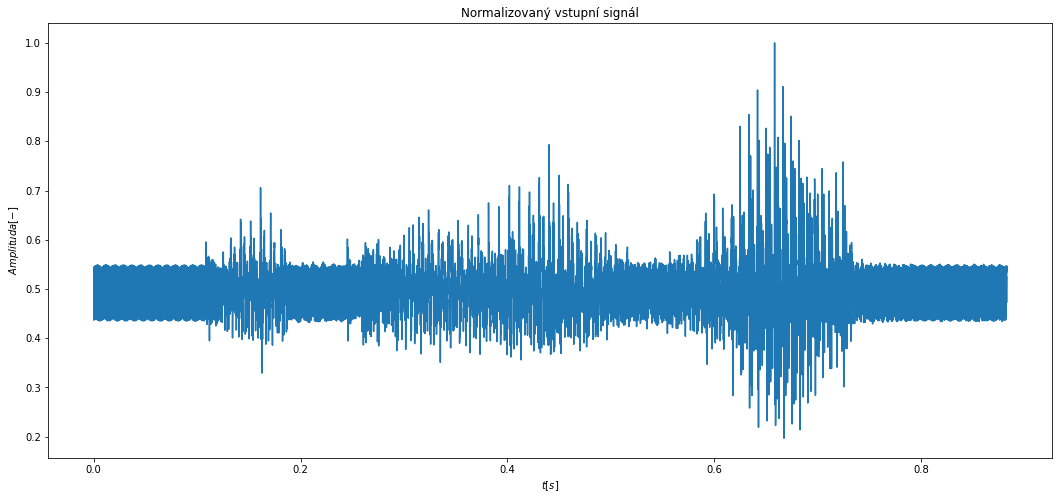

(12288,)


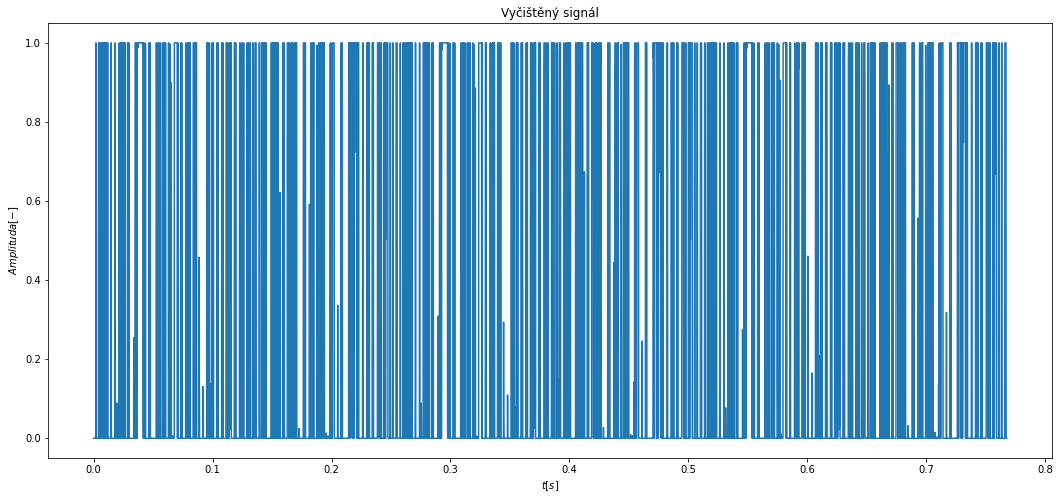

In [21]:
samples_orig, sample_freq = sf.read("../audio/xdousa00.wav")

samples_normal = normalization(samples_orig) + 1
samples_normal = normalization(samples_normal)

plt.figure(figsize=(18,8))
plt.title("Normalizovaný vstupní signál")
plt.plot(np.arange(samples_normal.size) / sample_freq, samples_normal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

cleared_signal = denoise(samples_normal, sample_freq)
norm_cleared_signal = normalization(cleared_signal)

print(norm_cleared_signal.shape)

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál")
plt.plot(np.arange(norm_cleared_signal.size) / sample_freq, norm_cleared_signal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

wavfile.write("clean_test.wav", sample_freq, norm_cleared_signal)

Cleanup

In [ ]:
if input("Are you sure you want to delete datasets?\n") == "y":
  shutil.rmtree(TRAIN_DATASET_PATH)
  shutil.rmtree(TEST_DATASET_PATH)